In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# load data
pd.options.display.max_columns = None
fires = pd.read_csv("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")
fires = fires[['ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','POOState','FireCauseGeneral','DiscoveryAcres','InitialLatitude','InitialLongitude']]
fires

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,FireCauseGeneral,DiscoveryAcres,InitialLatitude,InitialLongitude
0,2020/08/06 23:13:24+00,2020/08/06 23:13:07+00,2020/08/06 18:58:00+00,US-MT,Equipment,20.0,45.784960,-104.495800
1,NaN,NaN,2020/02/28 20:45:40+00,US-CA,NaN,0.1,33.808980,-118.180700
2,2017/10/18 00:35:00+00,2017/10/18 00:30:00+00,2017/10/17 20:20:24+00,US-MT,NaN,50.0,48.071670,-114.830300
3,NaN,NaN,2019/07/01 19:54:00+00,US-CA,NaN,NaN,NaN,NaN
4,NaN,NaN,2016/06/20 22:05:59+00,US-CA,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
211532,NaN,NaN,2022/03/14 19:46:52+00,US-CA,NaN,0.1,38.404329,-120.454859
211533,NaN,NaN,2022/03/14 18:52:51+00,US-TX,Undetermined,30.0,31.189829,-97.951463
211534,NaN,2022/03/14 15:59:59+00,2022/03/13 20:15:00+00,US-OK,NaN,3.4,35.358830,-96.185750
211535,NaN,NaN,2022/03/14 19:39:15+00,US-TX,Undetermined,5.0,33.021967,-94.564750


In [3]:
# fillna with values from another column

fires['ControlDateTime'].fillna(fires['ContainmentDateTime'], inplace=True)

fires['ControlDateTime'].isnull().sum()

81297

In [4]:
fires['CorrectControlDateTime'] = pd.to_datetime(fires['ControlDateTime'],errors='coerce')
errors = fires.loc[fires['CorrectControlDateTime'].isnull()]['ControlDateTime'].unique().tolist()
errors

[nan,
 '0214/08/14 21:34:00+00',
 '0214/08/05 07:00:00+00',
 '1159/10/22 17:00:00+00']

In [5]:
correct_dict = {'0214/08/14 21:34:00+00' : '2014/08/14 21:34:00+00',
                '0214/08/05 07:00:00+00' : '2014/08/05 07:00:00+00',
                '1159/10/22 17:00:00+00' : '2014/08/03 17:00:00+00'}
fires['ControlDateTime'] = fires['CorrectControlDateTime'].fillna(pd.to_datetime(fires['ControlDateTime'].map(correct_dict)))


In [6]:
fires['ControlDateTime'] = (pd.to_datetime(fires['ControlDateTime'],errors='coerce').dt.strftime('%Y/%m/%d %H:%M:%S'))
fires['ContainmentDateTime'] = (pd.to_datetime(fires['ContainmentDateTime'],errors='coerce').dt.strftime('%Y/%m/%d %H:%M:%S'))
fires['FireDiscoveryDateTime'] = (pd.to_datetime(fires['FireDiscoveryDateTime'],errors='coerce').dt.strftime('%Y/%m/%d %H:%M:%S'))
fires

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,FireCauseGeneral,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime
0,2020/08/06 23:13:24,2020/08/06 23:13:07,2020/08/06 18:58:00,US-MT,Equipment,20.0,45.784960,-104.495800,2020-08-06 23:13:24+00:00
1,NaN,NaN,2020/02/28 20:45:40,US-CA,NaN,0.1,33.808980,-118.180700,NaT
2,2017/10/18 00:35:00,2017/10/18 00:30:00,2017/10/17 20:20:24,US-MT,NaN,50.0,48.071670,-114.830300,2017-10-18 00:35:00+00:00
3,NaN,NaN,2019/07/01 19:54:00,US-CA,NaN,NaN,NaN,NaN,NaT
4,NaN,NaN,2016/06/20 22:05:59,US-CA,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...
211532,NaN,NaN,2022/03/14 19:46:52,US-CA,NaN,0.1,38.404329,-120.454859,NaT
211533,NaN,NaN,2022/03/14 18:52:51,US-TX,Undetermined,30.0,31.189829,-97.951463,NaT
211534,2022/03/14 15:59:59,2022/03/14 15:59:59,2022/03/13 20:15:00,US-OK,NaN,3.4,35.358830,-96.185750,2022-03-14 15:59:59+00:00
211535,NaN,NaN,2022/03/14 19:39:15,US-TX,Undetermined,5.0,33.021967,-94.564750,NaT


In [7]:
fires['ControlDateTime'] = pd.to_datetime(fires['ControlDateTime'])
fires['FireDiscoveryDateTime'] = pd.to_datetime(fires['FireDiscoveryDateTime'])

# make new variable of fire duration with date columns

fires['duration'] = (fires['ControlDateTime'] - fires['FireDiscoveryDateTime'])/np.timedelta64(1,'h')
fires


,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,FireCauseGeneral,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime,duration
0,2020-08-06 23:13:24,2020/08/06 23:13:07,2020-08-06 18:58:00,US-MT,Equipment,20.0,45.784960,-104.495800,2020-08-06 23:13:24+00:00,4.256667
1,NaT,NaN,2020-02-28 20:45:40,US-CA,NaN,0.1,33.808980,-118.180700,NaT,NaN
2,2017-10-18 00:35:00,2017/10/18 00:30:00,2017-10-17 20:20:24,US-MT,NaN,50.0,48.071670,-114.830300,2017-10-18 00:35:00+00:00,4.243333
3,NaT,NaN,2019-07-01 19:54:00,US-CA,NaN,NaN,NaN,NaN,NaT,NaN
4,NaT,NaN,2016-06-20 22:05:59,US-CA,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...
211532,NaT,NaN,2022-03-14 19:46:52,US-CA,NaN,0.1,38.404329,-120.454859,NaT,NaN
211533,NaT,NaN,2022-03-14 18:52:51,US-TX,Undetermined,30.0,31.189829,-97.951463,NaT,NaN
211534,2022-03-14 15:59:59,2022/03/14 15:59:59,2022-03-13 20:15:00,US-OK,NaN,3.4,35.358830,-96.185750,2022-03-14 15:59:59+00:00,19.749722
211535,NaT,NaN,2022-03-14 19:39:15,US-TX,Undetermined,5.0,33.021967,-94.564750,NaT,NaN


In [8]:
fires.duration.describe()

count    130240.000000
mean        125.584975
std         573.612423
min      -87580.983333
25%           1.496944
50%          10.850972
75%          50.091528
max        8759.970556
Name: duration, dtype: float64

In [9]:
fires['duration'].fillna(fires['duration'].mean())

0           4.256667
1         125.584975
2           4.243333
3         125.584975
4         125.584975
             ...    
211532    125.584975
211533    125.584975
211534     19.749722
211535    125.584975
211536    125.584975
Name: duration, Length: 211537, dtype: float64

In [10]:
fires['Year'] = pd.to_datetime(fires['FireDiscoveryDateTime']).dt.year
fires['Date'] = pd.to_datetime(fires['FireDiscoveryDateTime']).dt.date
fires['Time'] = pd.to_datetime(fires['FireDiscoveryDateTime']).dt.time
fires['Month'] = pd.DatetimeIndex(fires['Date']).month

fires['Date'] = pd.to_datetime(fires['Date']).dt.strftime("%Y%m%d").astype(int)
fires['Time'] = (pd.to_datetime(fires['FireDiscoveryDateTime']).astype(int)// 10**9).astype(int)

fires

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,FireCauseGeneral,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime,duration,Year,Date,Time,Month
0,2020-08-06 23:13:24,2020/08/06 23:13:07,2020-08-06 18:58:00,US-MT,Equipment,20.0,45.784960,-104.495800,2020-08-06 23:13:24+00:00,4.256667,2020,20200806,1596740280,8
1,NaT,NaN,2020-02-28 20:45:40,US-CA,NaN,0.1,33.808980,-118.180700,NaT,NaN,2020,20200228,1582922740,2
2,2017-10-18 00:35:00,2017/10/18 00:30:00,2017-10-17 20:20:24,US-MT,NaN,50.0,48.071670,-114.830300,2017-10-18 00:35:00+00:00,4.243333,2017,20171017,1508271624,10
3,NaT,NaN,2019-07-01 19:54:00,US-CA,NaN,NaN,NaN,NaN,NaT,NaN,2019,20190701,1562010840,7
4,NaT,NaN,2016-06-20 22:05:59,US-CA,NaN,NaN,NaN,NaN,NaT,NaN,2016,20160620,1466460359,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211532,NaT,NaN,2022-03-14 19:46:52,US-CA,NaN,0.1,38.404329,-120.454859,NaT,NaN,2022,20220314,1647287212,3
211533,NaT,NaN,2022-03-14 18:52:51,US-TX,Undetermined,30.0,31.189829,-97.951463,NaT,NaN,2022,20220314,1647283971,3
211534,2022-03-14 15:59:59,2022/03/14 15:59:59,2022-03-13 20:15:00,US-OK,NaN,3.4,35.358830,-96.185750,2022-03-14 15:59:59+00:00,19.749722,2022,20220313,1647202500,3
211535,NaT,NaN,2022-03-14 19:39:15,US-TX,Undetermined,5.0,33.021967,-94.564750,NaT,NaN,2022,20220314,1647286755,3


In [11]:
fires = fires[fires['POOState'].str.match('US-')]
fires = fires.sort_values(by='FireDiscoveryDateTime')

In [12]:
# convert string values to numerical categories
fires['POOState'] = fires['POOState'].map(lambda x: x.removeprefix("US-"))
fires['POOState'] = pd.Categorical(fires['POOState'])
fires["POOState"] = fires["POOState"].cat.codes

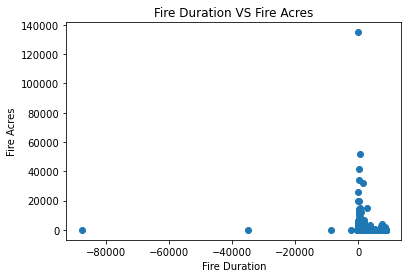

In [13]:
plt.scatter(fires['duration'], fires['DiscoveryAcres'])
plt.title('Fire Duration VS Fire Acres')
plt.xlabel('Fire Duration')
plt.ylabel('Fire Acres')
plt.show()

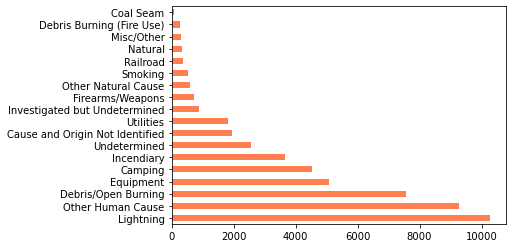

In [14]:
fires['FireCauseGeneral'].value_counts().plot(kind='barh',color='coral', alpha=1)
plt.show()

In [15]:
# Look at proportion of missing data
missing_prop = fires.isnull().sum()/fires.shape[0]
missing_prop[missing_prop != 0]

ControlDateTime           0.384280
ContainmentDateTime       0.398313
FireCauseGeneral          0.759804
DiscoveryAcres            0.283066
InitialLatitude           0.281198
InitialLongitude          0.281198
CorrectControlDateTime    0.384294
duration                  0.384280
dtype: float64

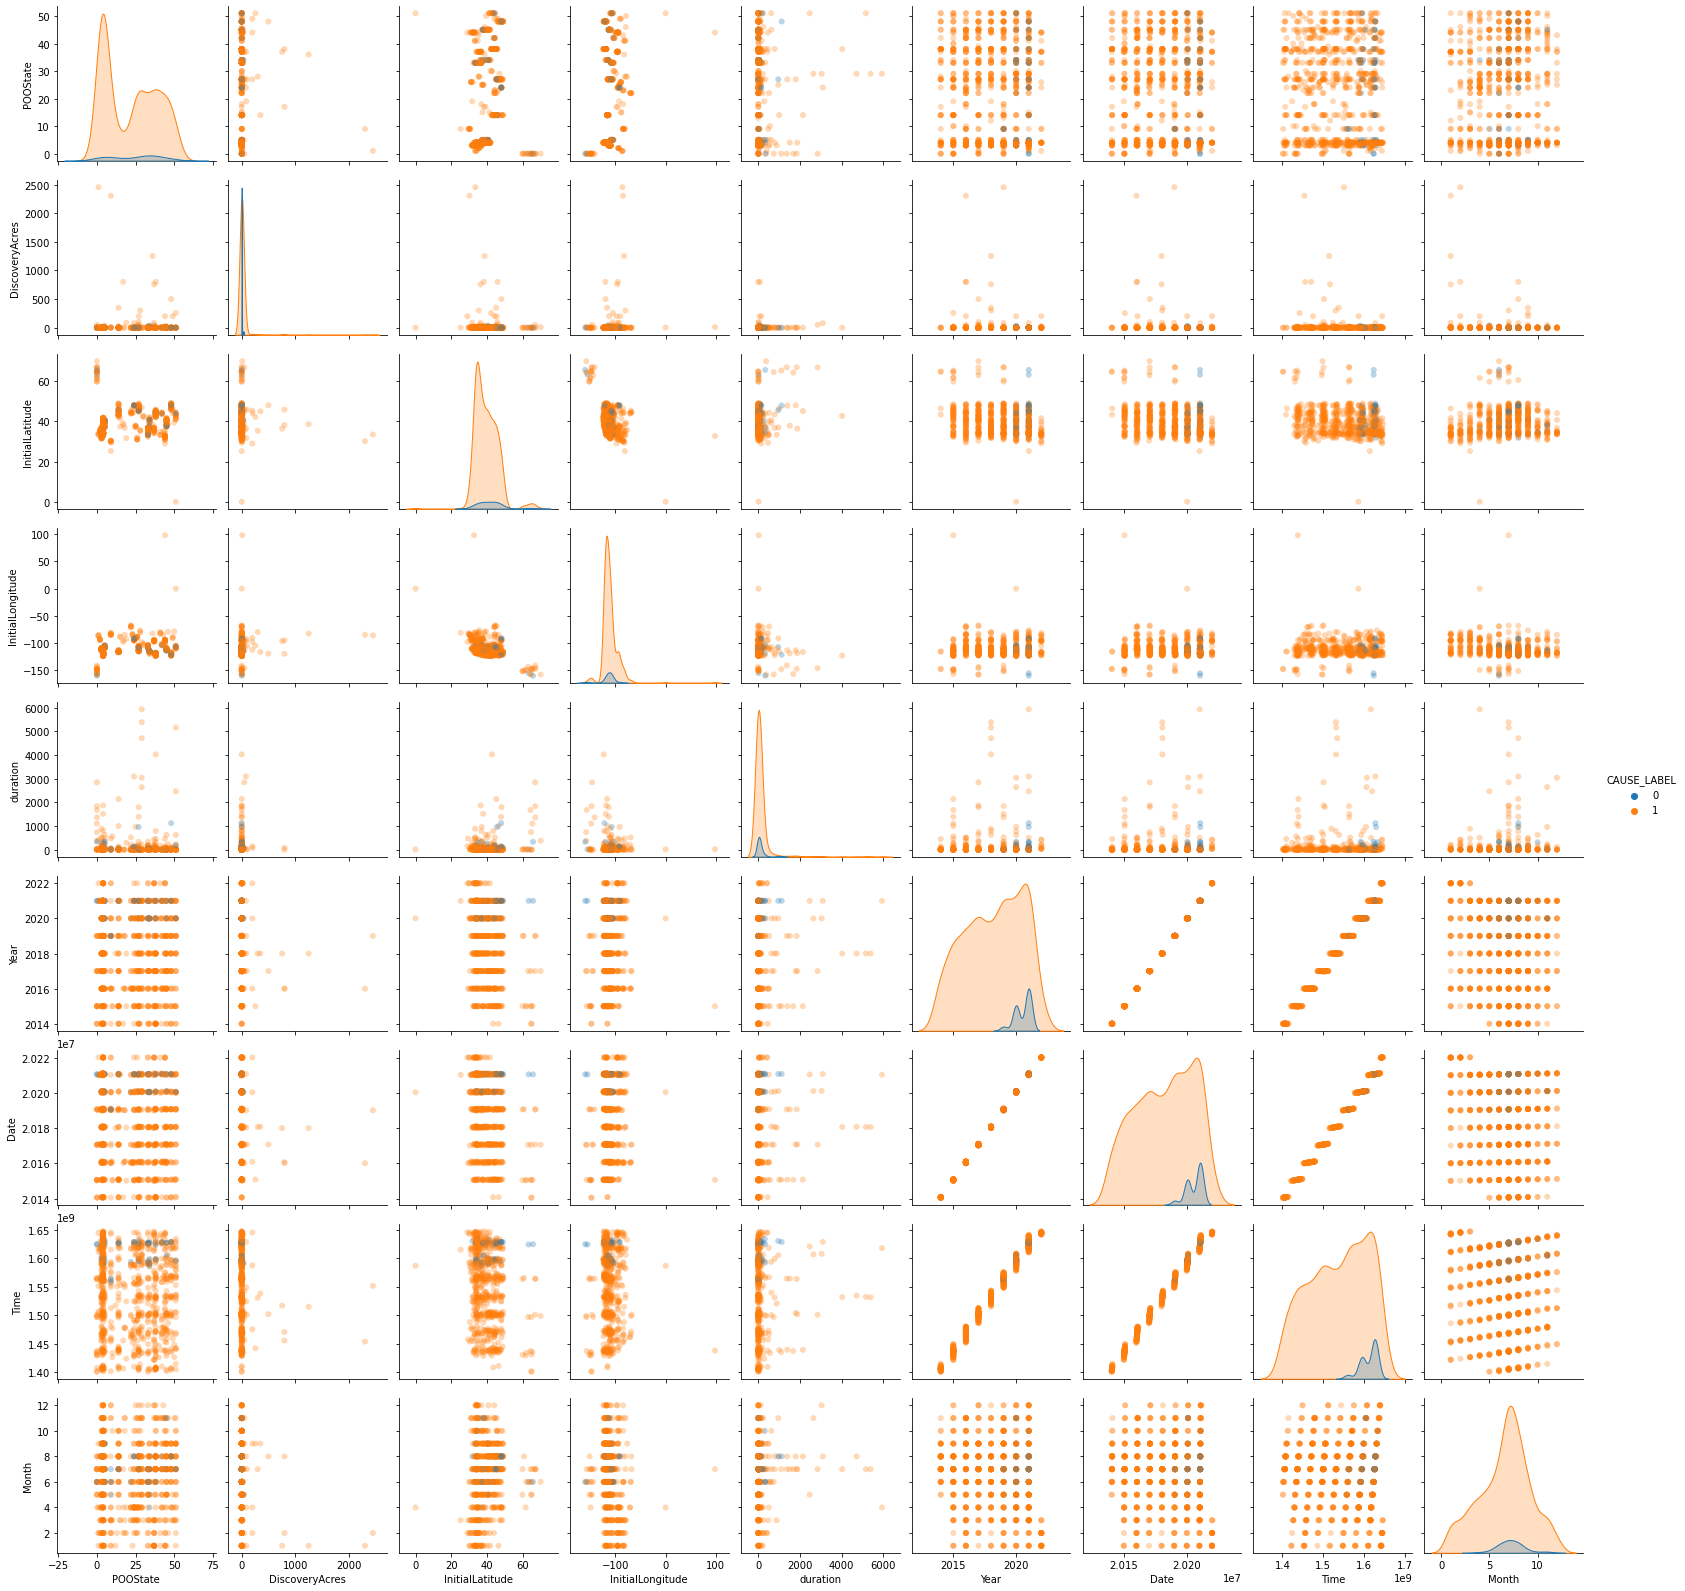

In [16]:
def label(cause_desc):
    if cause_desc == 'Lightning' :
        label = 0
    else:
        label = 1
    return label

fires['CAUSE_LABEL'] = fires.FireCauseGeneral.apply(label)

def plot_features(fires, sample_size=500):
    
    sample = (fires.drop(['FireCauseGeneral'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='CAUSE_LABEL', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(fires)

In [17]:
fires = fires.drop(['ControlDateTime', 'ContainmentDateTime', 'CorrectControlDateTime', 'Date', 'Time', 'FireDiscoveryDateTime'], axis=1)
fires = fires.fillna({'FireCauseGeneral':'Unknown', 'DiscoveryAcres': 0, 'InitialLatitude': 0, 'InitialLongitude': 0, 'duration': 0})
fires

,POOState,FireCauseGeneral,DiscoveryAcres,InitialLatitude,InitialLongitude,duration,Year,Month,CAUSE_LABEL
86653,51,Unknown,0.0,0.000000,0.000000,0.0,2003,1,1
147784,4,Unknown,0.0,0.000000,0.000000,0.0,2004,7,1
124012,14,Unknown,0.0,0.000000,0.000000,0.0,2008,7,1
147748,14,Unknown,1.0,42.103889,-111.547778,0.0,2008,9,1
99688,3,Unknown,0.0,34.389999,-112.080002,0.0,2008,10,1
...,...,...,...,...,...,...,...,...,...
211531,4,Unknown,0.1,33.691797,-117.225950,0.0,2022,3,1
211533,44,Undetermined,30.0,31.189829,-97.951463,0.0,2022,3,1
211535,44,Undetermined,5.0,33.021967,-94.564750,0.0,2022,3,1
211532,4,Unknown,0.1,38.404329,-120.454859,0.0,2022,3,1


# Evaluate multiple Classifiers

In [18]:
import time 

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB

X = fires.drop(['FireCauseGeneral'], axis=1).values
y = np.asarray(fires['FireCauseGeneral'], dtype="|S6")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

def fit_model(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start 
    score = model.score(X_test, y_test)
    
    print("{} fit in {:0.2f} seconds score: {:0.4f}".format(model.__class__.__name__, duration, score))
    print(model.get_params())

In [19]:
# Try them all!

models = (
    LogisticRegression(), 
    SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    Perceptron(), 
    KNeighborsClassifier(),
    ExtraTreesClassifier(n_estimators=100),
    SGDClassifier(max_iter=100, tol=1e-3),
    GaussianNB(), 
    BaggingClassifier()
    #MultinomialNB(alpha=0.01) contain negative valuse, can't be used
)

for model in models:
    fit_model(model)
    print()

LogisticRegression fit in 8.41 seconds score: 0.7574
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

SVC fit in 2436.60 seconds score: 0.7579
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

RandomForestClassifier fit in 13.09 seconds score: 0.8728
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimat

# Prepare Data for Modeling and Evaluating

In [20]:
# trim to the predictor variables of interest
predictors = fires[['Year', 'Month','DiscoveryAcres', 'POOState', 
                    'InitialLatitude','InitialLongitude', 'duration']]
target = fires['FireCauseGeneral']

## encode all categorical variables including the fire causes
# make labelEncoder for fire causes
cause_encode = skl.preprocessing.LabelEncoder()
cause_encode.fit(list(target.values)) 
target = cause_encode.transform(list(target.values))

In [21]:
# Id the numberic columns before label encoding so we can scale them later
num_cols = predictors.select_dtypes(include='number').columns
num_cols

Index(['Year', 'Month', 'DiscoveryAcres', 'POOState', 'InitialLatitude',
       'InitialLongitude', 'duration'],
      dtype='object')

In [22]:
# training/test split (hold out 1/5 of the data for testing)
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(predictors, target, test_size = 0.2)

In [23]:
def scale_impute(x_data, num_cols):
    # scale numberic columns of x data
    mm_scaler = skl.preprocessing.MinMaxScaler(feature_range=(0, 1))
    qt_scaler = skl.preprocessing.QuantileTransformer(output_distribution="normal")
    
    # Suppress setting with copy warning
    pd.options.mode.chained_assignment = None
    
    num_cols = num_cols.drop("DiscoveryAcres")
    x_scaled = mm_scaler.fit_transform(x_data[num_cols])
    x_data[num_cols] = x_scaled
    
    # Use quantile transform on fire size because of extreme outliers
    qt = QuantileTransformer()
    fire_size_scaled = qt.fit_transform(np.array(fires["DiscoveryAcres"]).reshape(-1,1))
    fire_size_scaled = pd.Series(fire_size_scaled[:,0])
    x_data["DiscoveryAcres"] = fire_size_scaled

    
    # make new columns indicating what will be imputed
    cols_with_missing = [col for col in x_data.columns 
                                 if x_data[col].isnull().any()]
    
    for col in cols_with_missing:
        x_data[col + '_was_missing'] = x_data[col].isnull()

    col_names = x_data.columns
    
    
    # Imputation
    my_imputer = SimpleImputer()
    x_data = pd.DataFrame(my_imputer.fit_transform(x_data))
    x_data.columns = col_names
    
    #x_data = x_data.drop("source_system_fed_was_missing", axis=1)
    
    return(x_data)

In [24]:
X_train_imp = scale_impute(X_train, num_cols)
X_train_imp.head()

X_test_imp = scale_impute(X_test, num_cols)
X_test_imp.head()

,Year,Month,DiscoveryAcres,POOState,InitialLatitude,InitialLongitude,duration,DiscoveryAcres_was_missing
0,0.722222,0.454545,0.918919,0.882353,0.307001,0.734679,0.189242,0.0
1,0.666667,0.272727,0.773273,0.764706,0.000000,0.833425,0.214342,0.0
2,0.722222,0.000000,0.510511,0.509804,0.000000,0.833425,0.190890,0.0
3,0.666667,0.636364,0.510511,0.529412,0.000000,0.833425,0.191488,0.0
4,0.722222,0.545455,0.510511,0.078431,0.000000,0.833425,0.186977,0.0


# Predicting the causes of wildfires

In [25]:
# This function is taken from with slight modifications: https://bit.ly/2DCTGd5 
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Evaluating Classifiers

Random Forest Classifier

In [26]:
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [3, 5, None] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 10] # minimum sample number to split a node

# create the random grid
multiclass_rf_grid = {
    'n_estimators': [100],
    'min_samples_split': min_samples_split,
    'max_features': max_features}

multiclass_rf_cv = skl.model_selection.GridSearchCV(RandomForestClassifier(), multiclass_rf_grid,
                                               cv=3, 
                                               scoring = "accuracy")

multiclass_rf_cv.fit(X_train_imp, y_train)

multiclass_rf_pred = multiclass_rf_cv.predict(X_test_imp)
acc_score = accuracy_score(multiclass_rf_pred, y_test)

# Displaying results

print(f"Accuracy Score: {acc_score}")
print("RandomForest Classification Report")
print(classification_report(multiclass_rf_pred, y_test))

Accuracy Score: 0.7614713600151297
RandomForest Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.05      0.37      0.09       267
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.23      0.00        13
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          1

In [27]:
multiclass_rf_cv.best_params_

{'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 100}

In [28]:
y_test_labels = cause_encode.inverse_transform(y_test)
multiclass_rf_pred_labels = cause_encode.inverse_transform(multiclass_rf_pred)
causes = cause_encode.inverse_transform(list(range(0,19)))

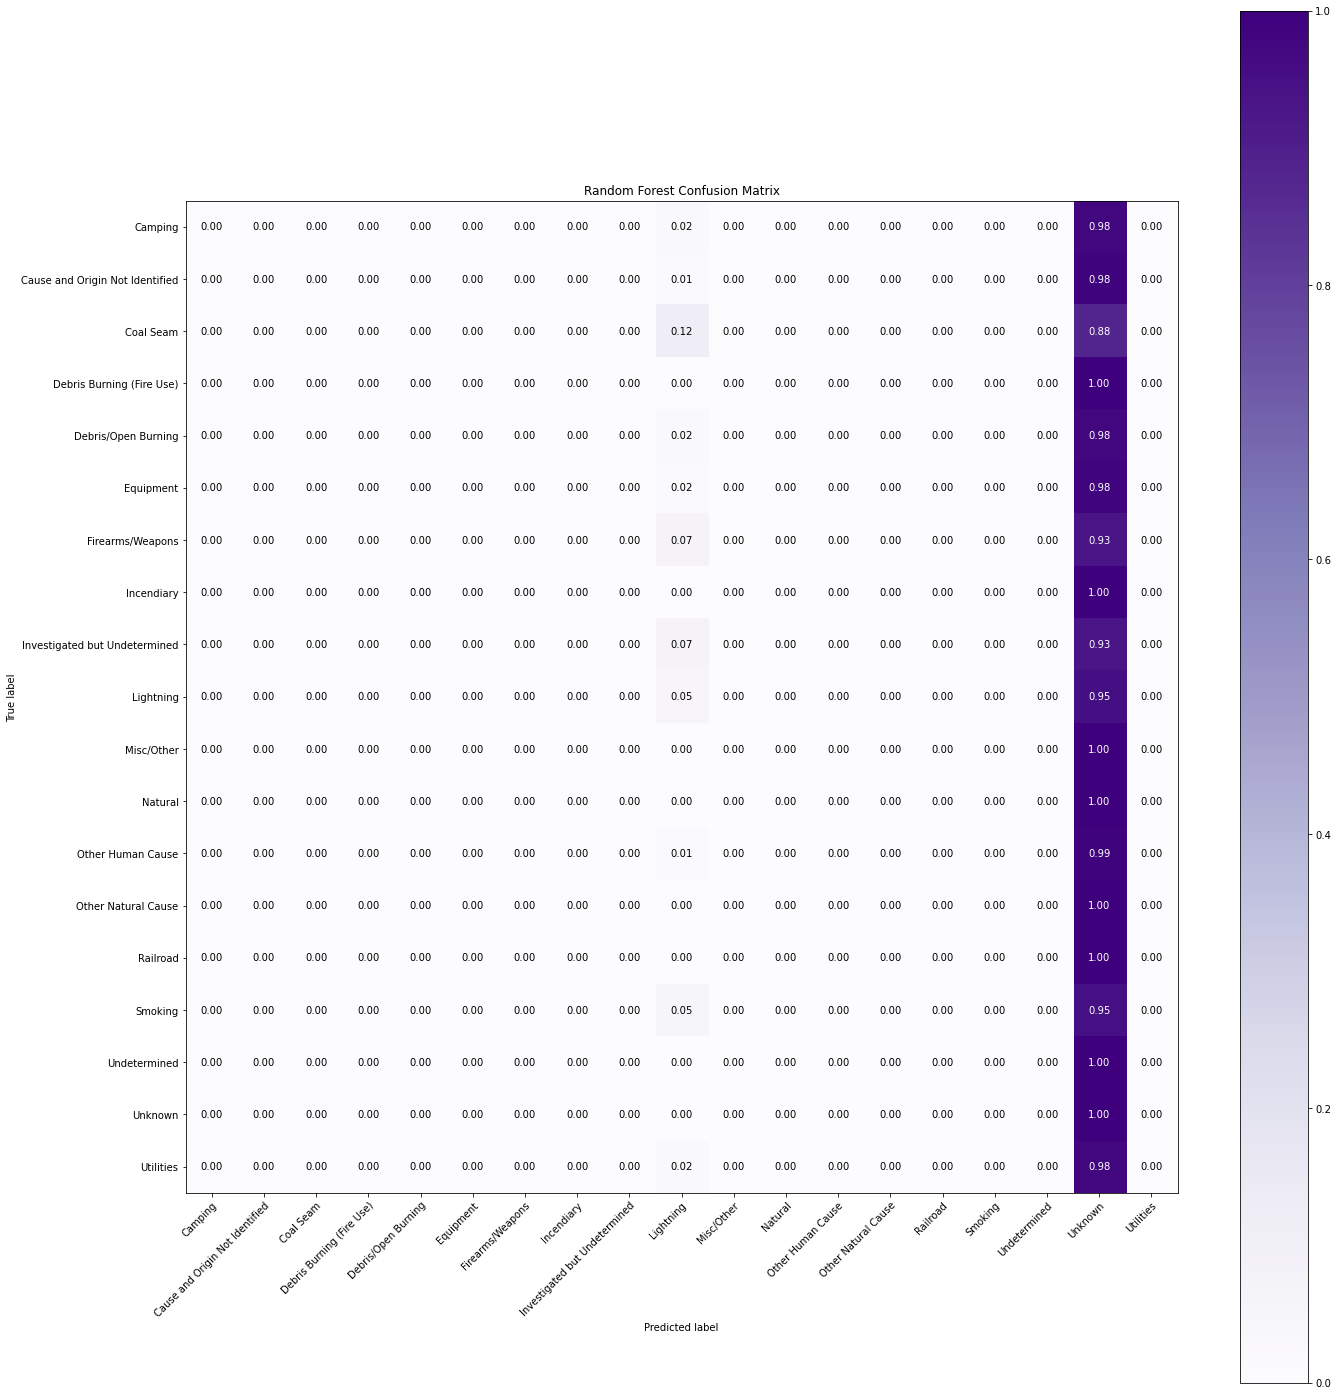

In [29]:
plot_confusion_matrix(y_test_labels, multiclass_rf_pred_labels, causes, normalize=True)
_=plt.title("Random Forest Confusion Matrix")

KNeighbors Classifier

In [30]:
# create knn grid

multiclass_knn_grid = {
    "p":[1,2],
    "n_neighbors":[3,5]
}

multiclass_knn_cv = skl.model_selection.GridSearchCV(KNeighborsClassifier(), multiclass_knn_grid,
                                               cv=3, 
                                               scoring = "accuracy")

multiclass_knn_cv.fit(X_train_imp, y_train)

multiclass_knn_pred = multiclass_knn_cv.predict(X_test_imp)
acc_score = accuracy_score(multiclass_knn_pred, y_test)

# displaying results

print(f"Accuracy Score: {acc_score}")
print("KNeighbors Classification Report")
print(classification_report(multiclass_knn_pred, y_test))

Accuracy Score: 0.7729368100044917
KNeighbors Classification Report
              precision    recall  f1-score   support

           0       0.27      0.18      0.21      1387
           1       0.28      0.24      0.26       456
           2       0.00      0.00      0.00         8
           3       0.04      0.09      0.05        22
           4       0.19      0.26      0.22      1127
           5       0.05      0.11      0.07       463
           6       0.09      0.14      0.11        97
           7       0.11      0.17      0.13       423
           8       0.01      0.05      0.01        19
           9       0.31      0.45      0.37      1453
          10       0.13      0.33      0.19        27
          11       0.39      0.61      0.48        49
          12       0.17      0.20      0.18      1619
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         6
          15       0.01      0.12      0.02         8
          16 

In [31]:
multiclass_knn_cv.best_params_

{'n_neighbors': 5, 'p': 1}

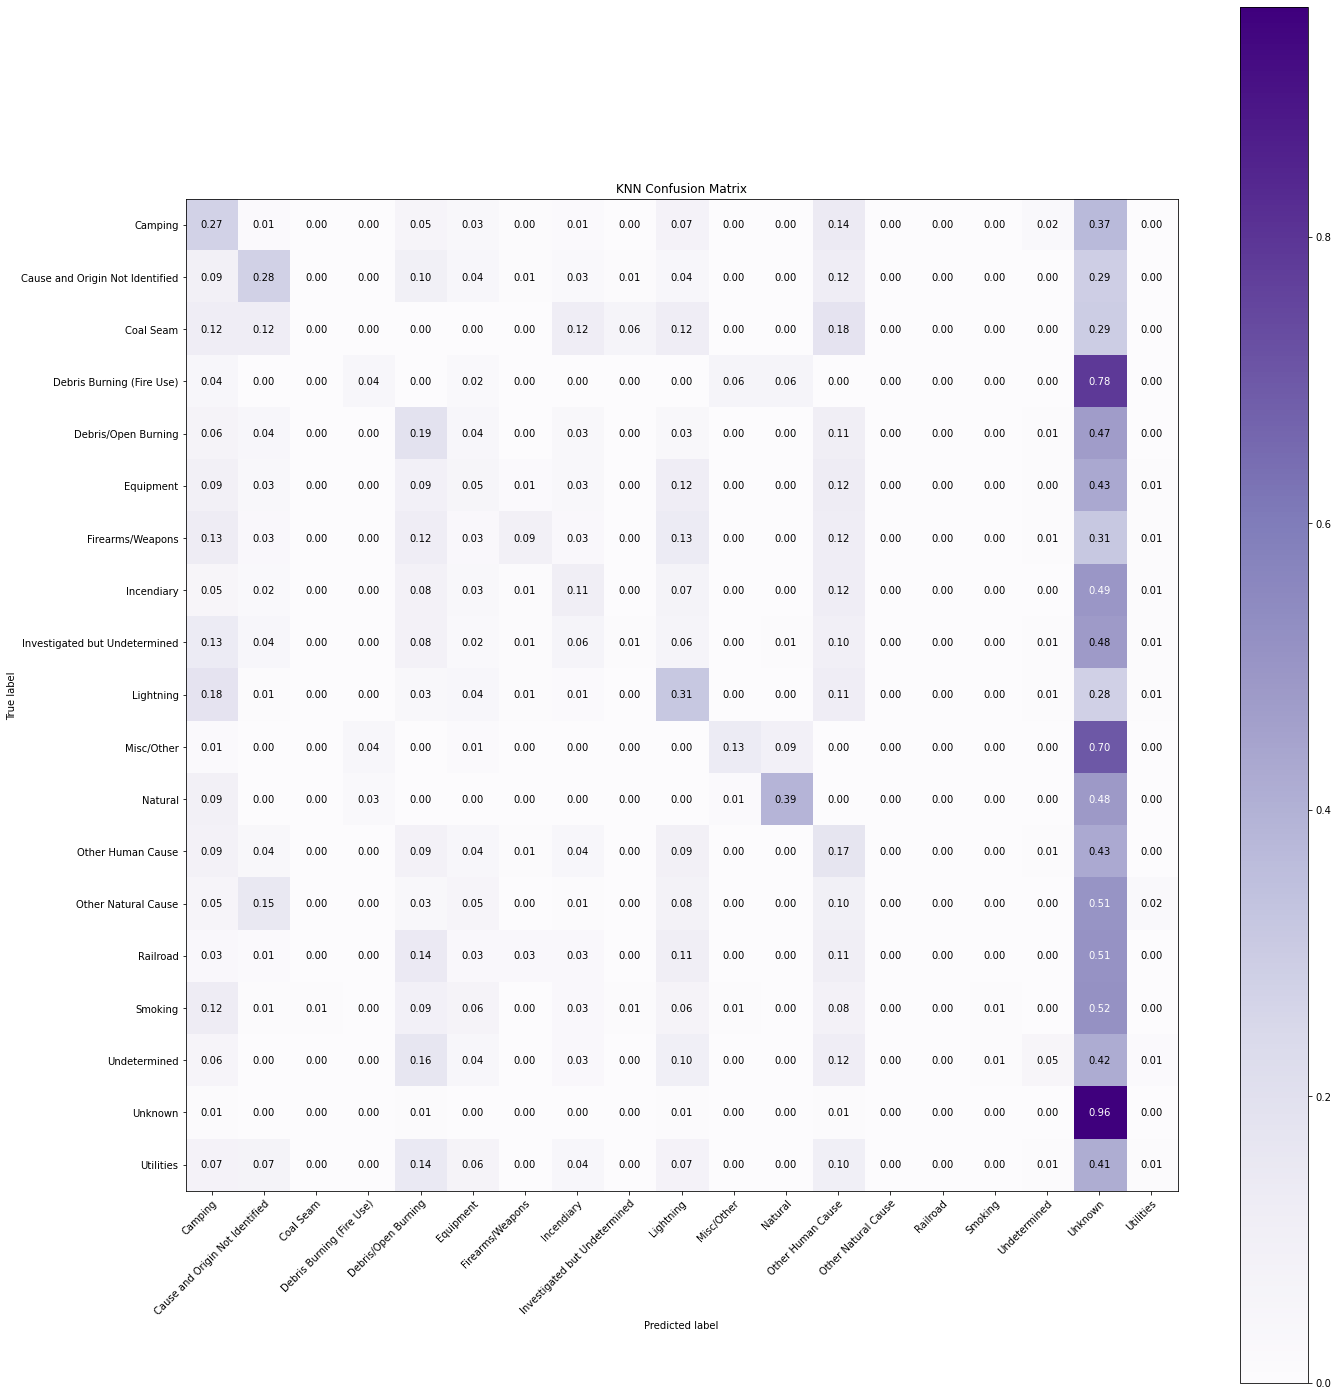

In [32]:
multiclass_knn_pred_labels = cause_encode.inverse_transform(multiclass_knn_pred)
plot_confusion_matrix(y_test_labels, multiclass_knn_pred_labels, causes, normalize=True)
_=plt.title("KNN Confusion Matrix")

Gradient Boosting Classifier

In [33]:
# create gradient boosting grid

multiclass_gb_grid = {"n_estimators": [100],
                      "criterion": ['friedman_mse'], 
                      "max_depth": [3],
                      "random_state": [None]}

multiclass_gb_cv = skl.model_selection.GridSearchCV(GradientBoostingClassifier(), multiclass_gb_grid,
                                               cv=3, 
                                               scoring = "accuracy")

multiclass_gb_cv.fit(X_train_imp, y_train)

multiclass_gb_pred = multiclass_gb_cv.predict(X_test_imp)
acc_score = accuracy_score(multiclass_gb_pred, y_test)

# displaying results

print(f"Accuracy Score: {acc_score}")
print("GradientBoosting Classification Report")
print(classification_report(multiclass_gb_pred, y_test))

Accuracy Score: 0.4489728375215716
GradientBoosting Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.12      0.02      0.04      2057
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00        18
           5       0.01      0.17      0.02        72
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00        25
           9       0.06      0.06      0.06      2065
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00      1913
          12       0.27      0.05      0.08     10134
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
       

In [34]:
multiclass_gb_cv.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 3,
 'n_estimators': 100,
 'random_state': None}

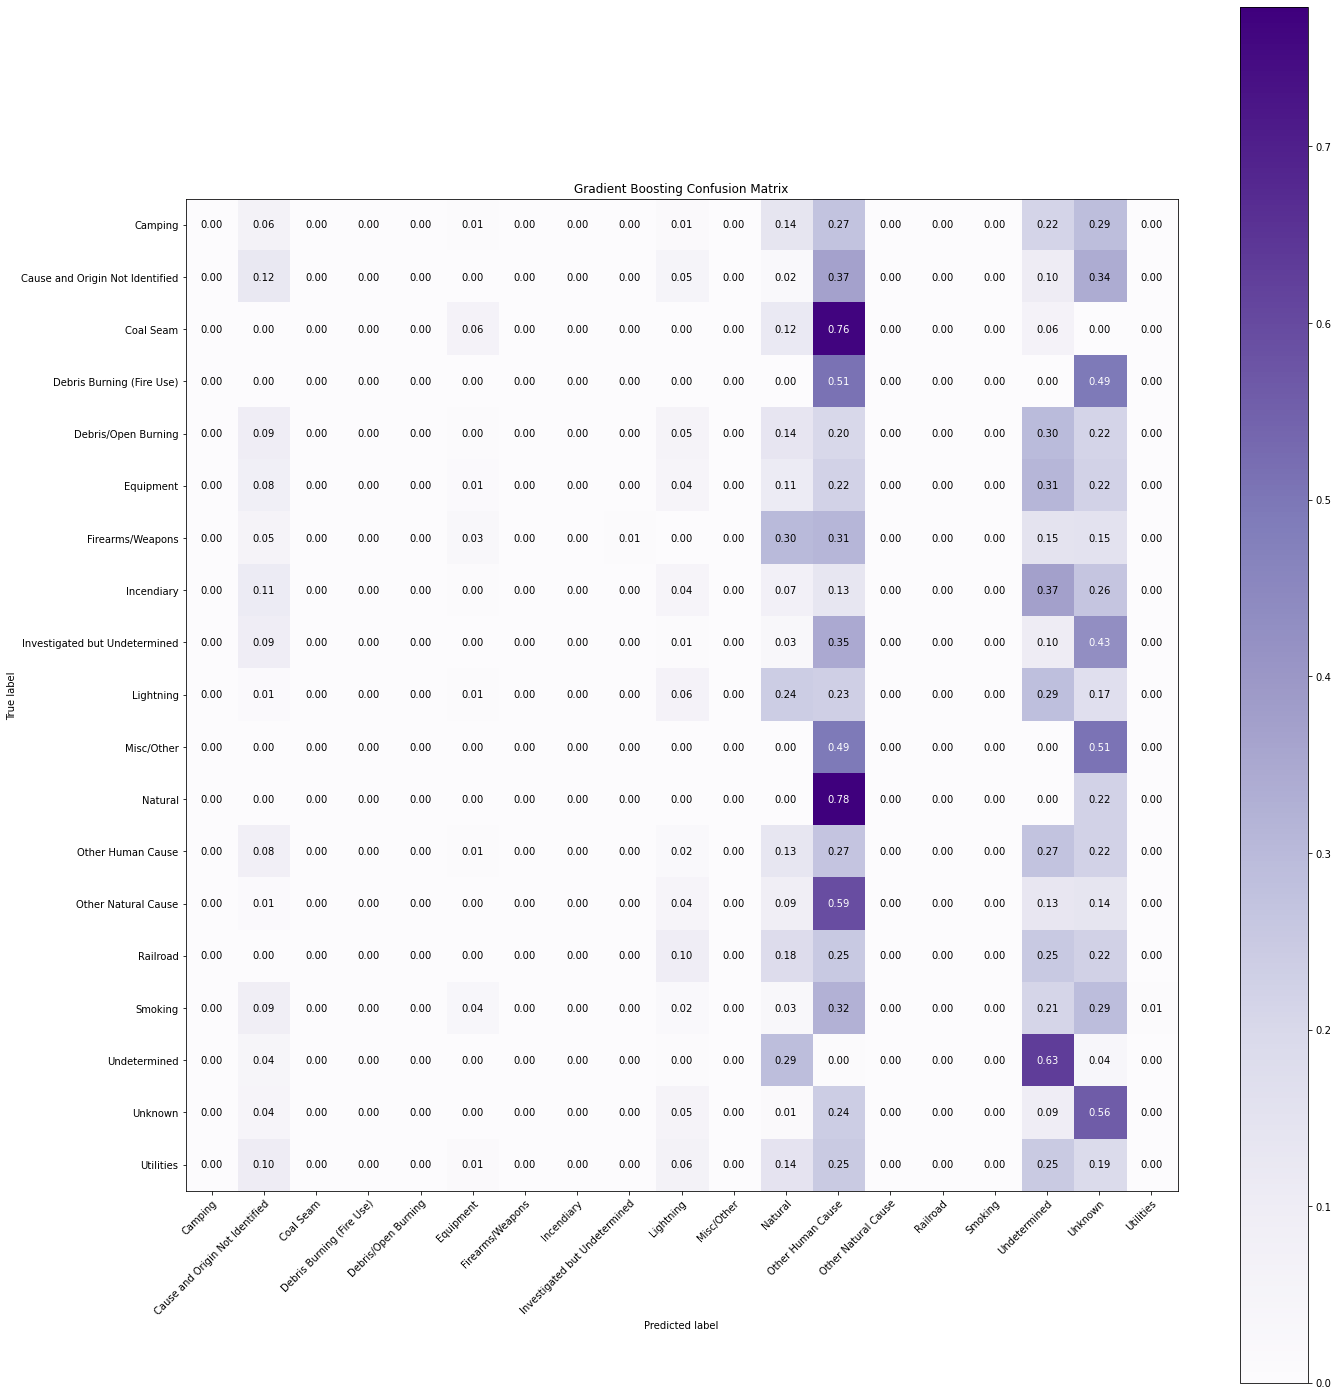

In [35]:
multiclass_gb_pred_labels = cause_encode.inverse_transform(multiclass_gb_pred)
causes = cause_encode.inverse_transform(list(range(0,19)))
plot_confusion_matrix(y_test_labels, multiclass_gb_pred_labels, causes, normalize=True)
_=plt.title("Gradient Boosting Confusion Matrix")

Decision Tree Classifier

In [36]:
from sklearn.tree import DecisionTreeClassifier

multiclass_dt = DecisionTreeClassifier(random_state=0)

multiclass_dt.fit(X_train_imp, y_train)
multiclass_dt_pred = multiclass_dt.predict(X_test_imp)

acc_score = accuracy_score(multiclass_dt_pred, y_test)

# Displaying results

print(f"Accuracy Score: {acc_score}")
print("DecisionTree Classification Report")
print(classification_report(multiclass_dt_pred, y_test))                            

Accuracy Score: 0.5095860617952295
DecisionTree Classification Report
              precision    recall  f1-score   support

           0       0.12      0.09      0.10      1172
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.06      0.27      0.10       332
           5       0.11      0.11      0.11      1069
           6       0.05      0.01      0.02       553
           7       0.01      0.09      0.02       104
           8       0.00      0.00      0.00         4
           9       0.12      0.14      0.13      1718
          10       0.01      0.12      0.03         8
          11       0.44      0.02      0.04      1635
          12       0.28      0.05      0.09     10281
          13       0.00      0.00      0.00         2
          14       0.10      0.02      0.03       379
          15       0.06      0.03      0.04       221
          1

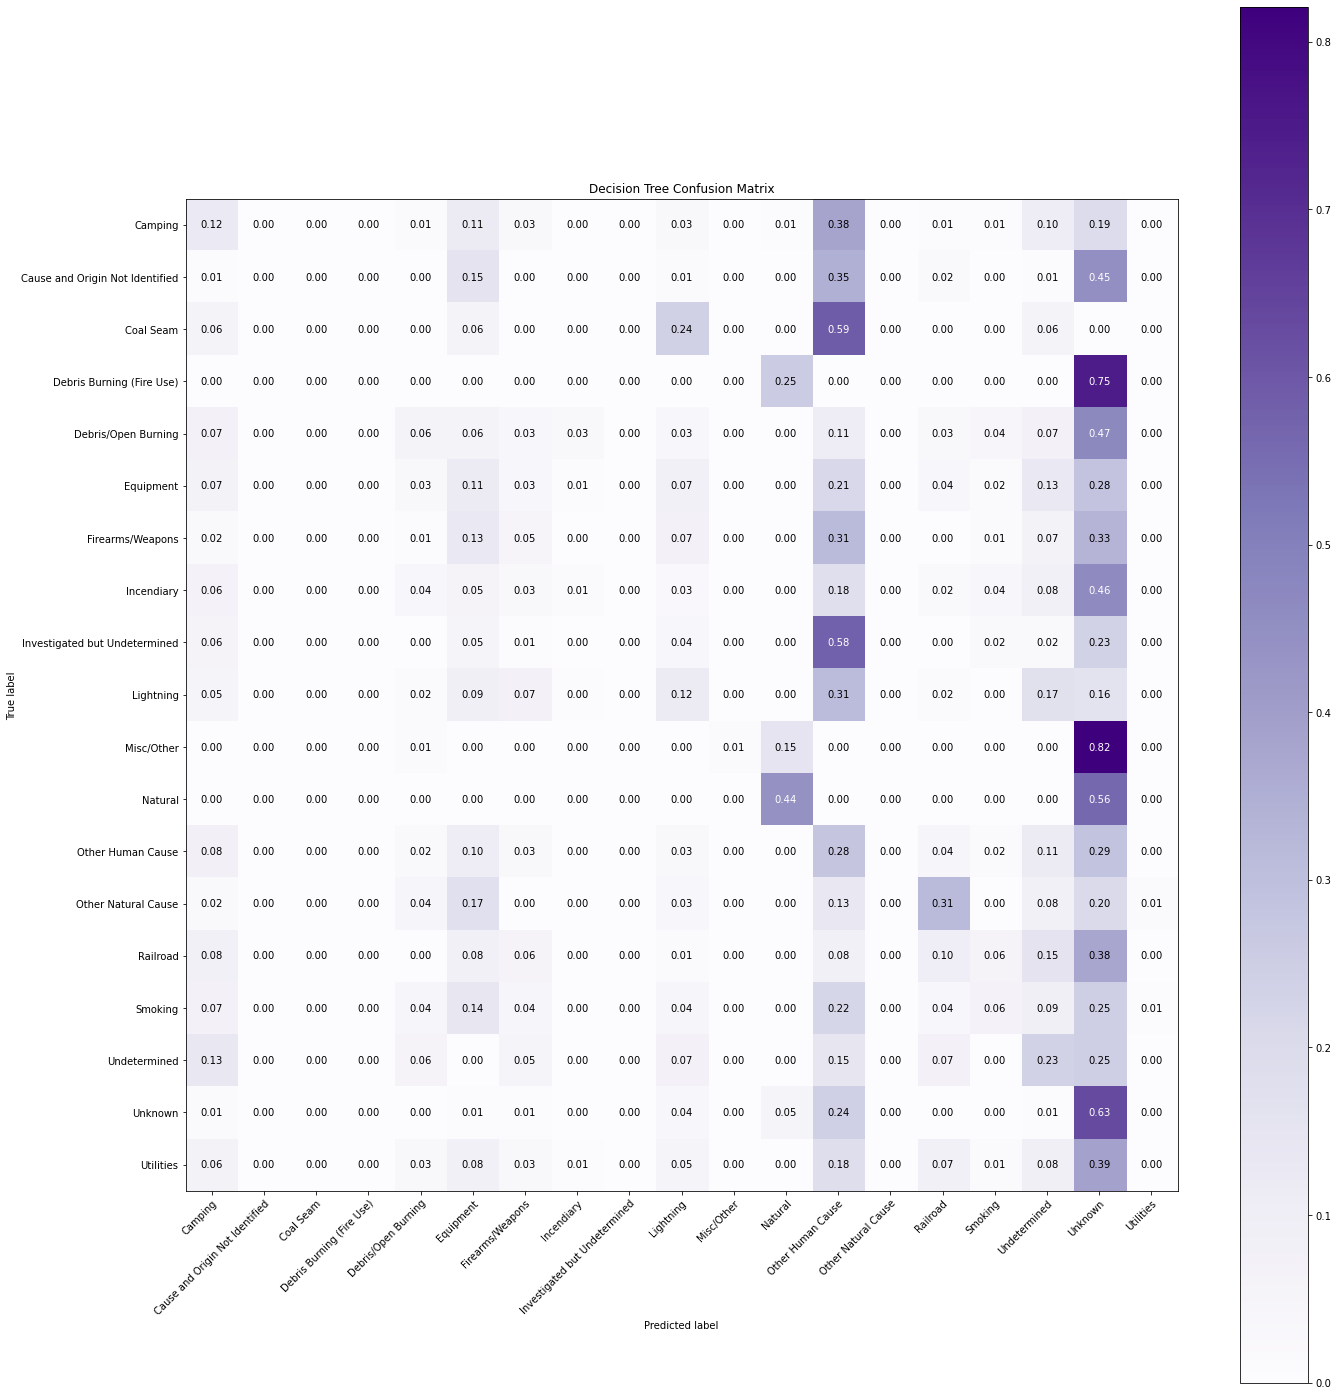

In [37]:
multiclass_dt_pred_labels = cause_encode.inverse_transform(multiclass_dt_pred)
causes = cause_encode.inverse_transform(list(range(0,19)))
plot_confusion_matrix(y_test_labels, multiclass_dt_pred_labels, causes, normalize=True)
_=plt.title("Decision Tree Confusion Matrix")

Extra Trees Classifier

In [38]:
from sklearn.ensemble import ExtraTreesClassifier

multiclass_et = ExtraTreesClassifier(n_estimators=100, random_state=0)

multiclass_et.fit(X_train_imp, y_train)
multiclass_et_pred = multiclass_et.predict(X_test_imp)

acc_score = accuracy_score(multiclass_et_pred, y_test)

# Displaying results

print(f"Accuracy Score: {acc_score}")
print("ExtraTrees Classification Report")
print(classification_report(multiclass_et_pred, y_test))                            

Accuracy Score: 0.7618732417673341
ExtraTrees Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.01      0.28      0.01        32
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.04      0.52      0.07       142
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.29      0.01        24
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16 

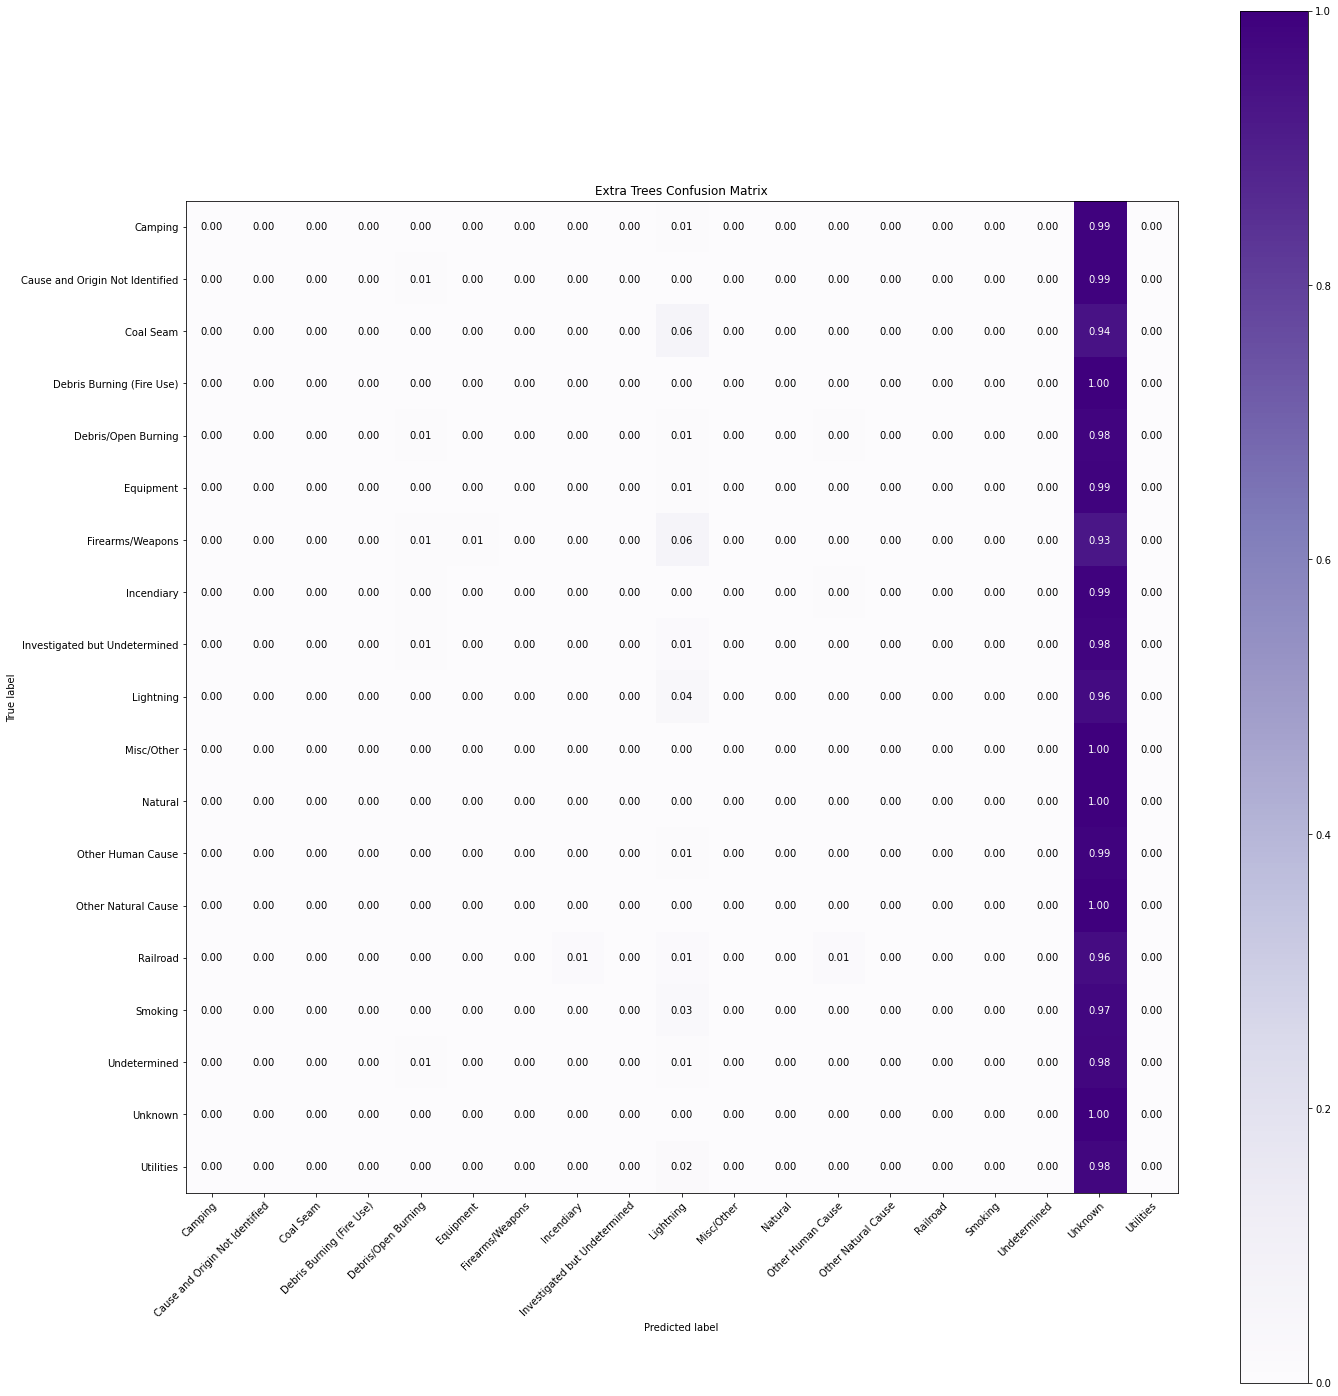

In [39]:
multiclass_et_pred_labels = cause_encode.inverse_transform(multiclass_et_pred)
causes = cause_encode.inverse_transform(list(range(0,19)))
plot_confusion_matrix(y_test_labels, multiclass_et_pred_labels, causes, normalize=True)
_=plt.title("Extra Trees Confusion Matrix")

Bagging Classifier

In [40]:
multiclass_bc = BaggingClassifier(n_estimators=10, random_state=0)

multiclass_bc.fit(X_train_imp, y_train)
multiclass_bc_pred = multiclass_bc.predict(X_test_imp)

acc_score = accuracy_score(multiclass_bc_pred, y_test)

# Displaying results

print(f"Accuracy Score: {acc_score}")
print("Bagging Classification Report")
print(classification_report(multiclass_bc_pred, y_test))

Accuracy Score: 0.5199877071464032
Bagging Classification Report
              precision    recall  f1-score   support

           0       0.14      0.11      0.12      1228
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.07      0.11      0.09      1047
           5       0.02      0.06      0.03       269
           6       0.01      0.00      0.00       329
           7       0.02      0.06      0.03       197
           8       0.00      0.00      0.00         1
           9       0.08      0.05      0.06      3203
          10       0.01      1.00      0.03         1
          11       0.00      0.00      0.00        17
          12       0.15      0.03      0.05      9136
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         9
          15       0.01      0.33      0.02         3
          16    

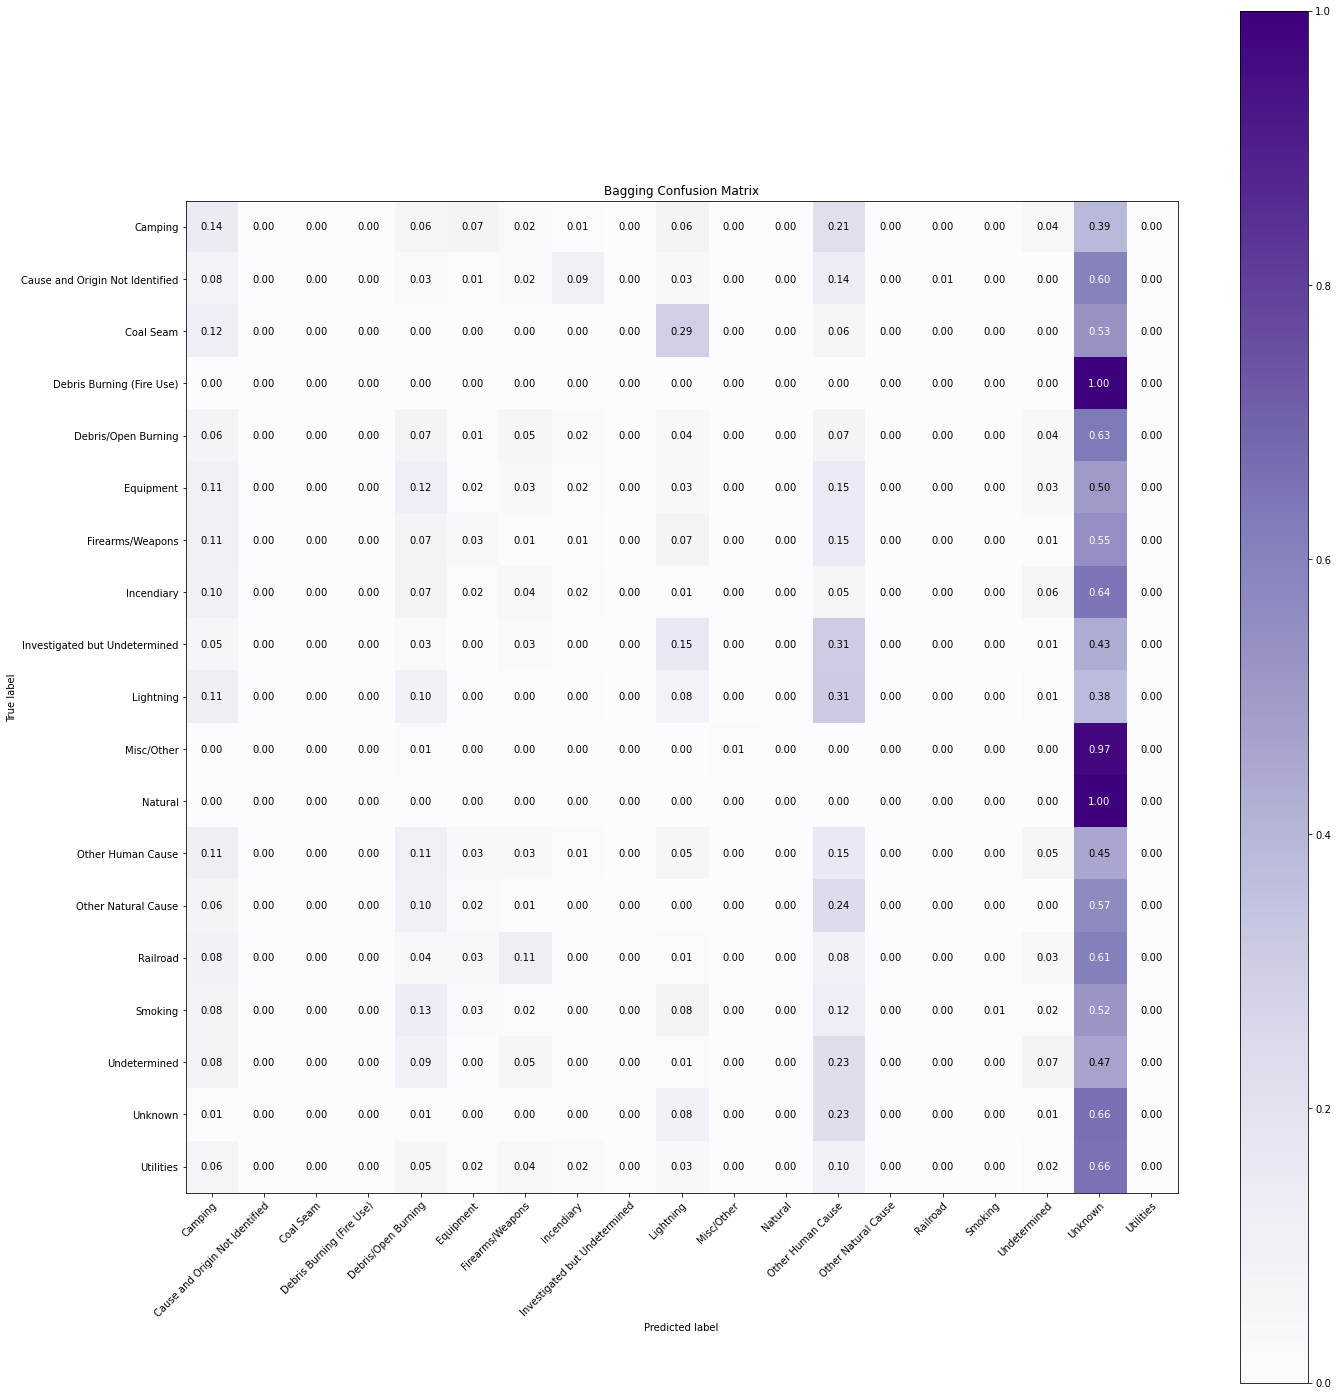

In [41]:
multiclass_bc_pred_labels = cause_encode.inverse_transform(multiclass_bc_pred)
causes = cause_encode.inverse_transform(list(range(0,19)))
plot_confusion_matrix(y_test_labels, multiclass_bc_pred_labels, causes, normalize=True)
_=plt.title("Bagging Confusion Matrix")

Ada Boost Classifier

In [42]:
multiclass_ab = AdaBoostClassifier(n_estimators=10, random_state=0)

multiclass_ab.fit(X_train_imp, y_train)
multiclass_ab_pred = multiclass_ab.predict(X_test_imp)

acc_score = accuracy_score(multiclass_ab_pred, y_test)

# Displaying results

print(f"Accuracy Score: {acc_score}")
print("Ada Boost Classification Report")
print(classification_report(multiclass_ab_pred, y_test))

Accuracy Score: 0.7448050873501808
Ada Boost Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.02      0.08      0.03        13
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.01      0.01      0.01       280
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.36      0.25      0.29      3020
          10       0.22      0.03      0.05       491
          11       0.00      0.00      0.00         0
          12       0.06      0.14      0.08       761
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16  

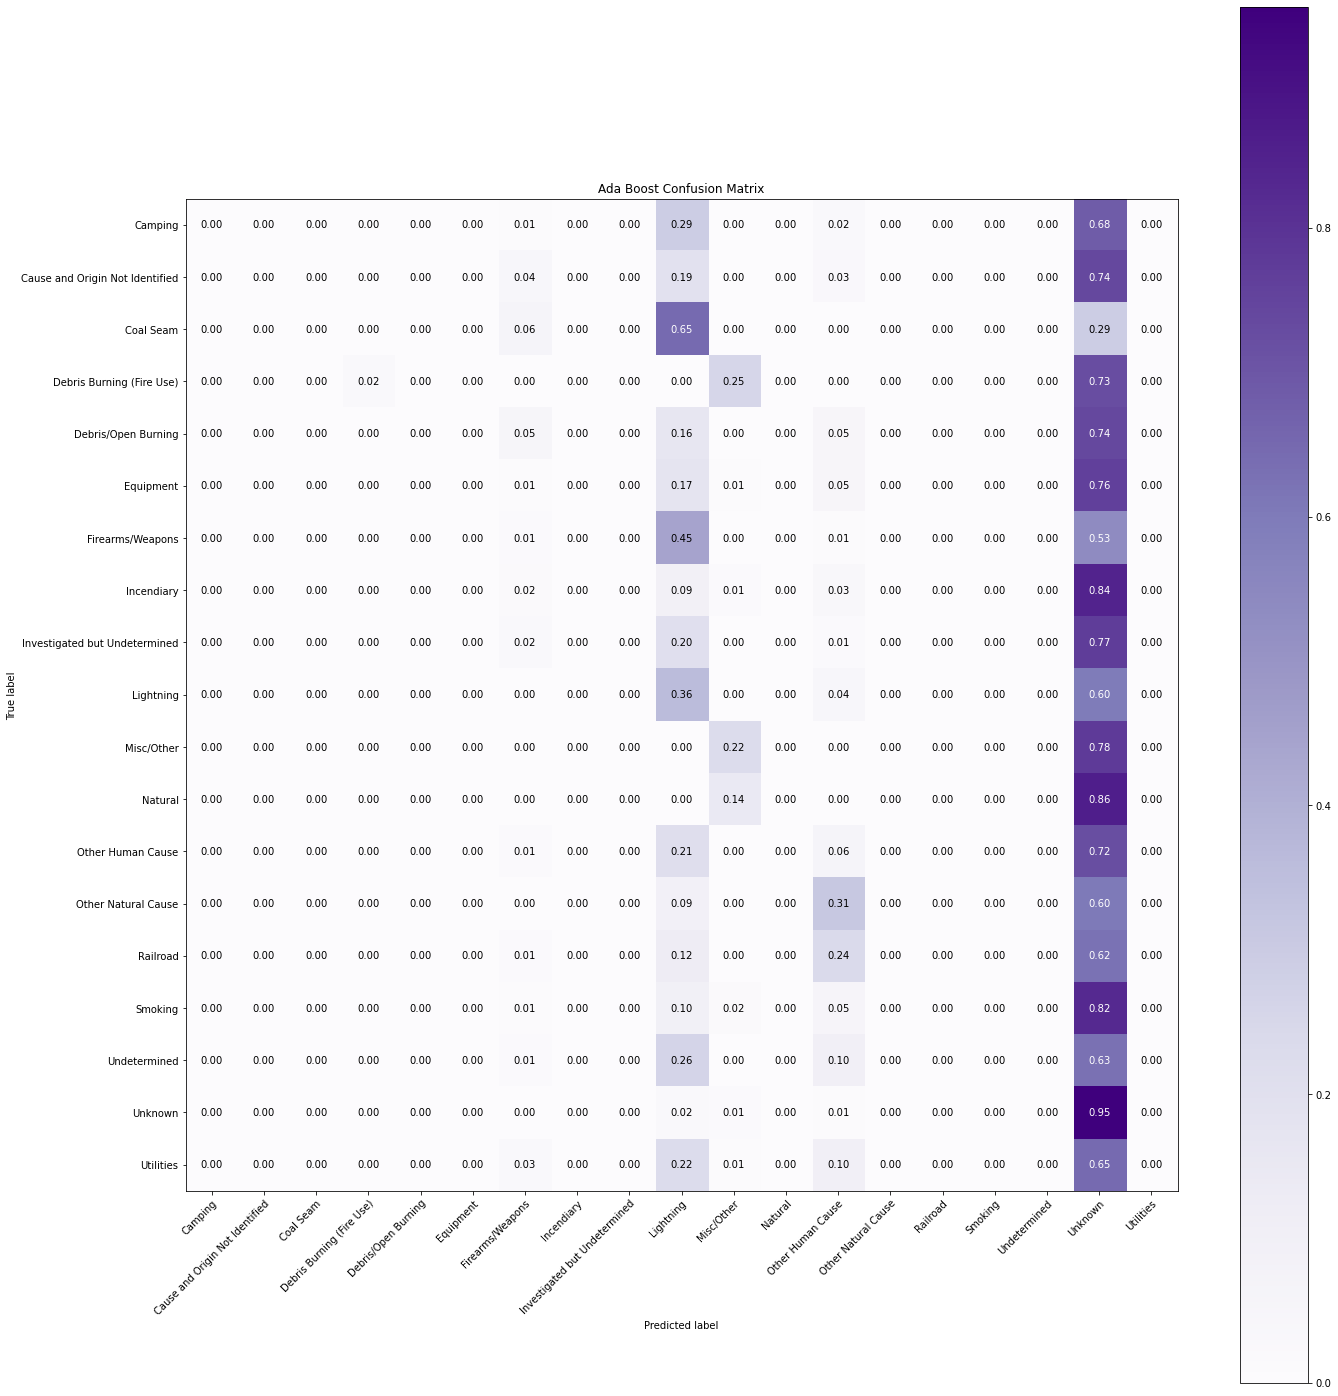

In [43]:
multiclass_ab_pred_labels = cause_encode.inverse_transform(multiclass_ab_pred)
causes = cause_encode.inverse_transform(list(range(0,19)))
plot_confusion_matrix(y_test_labels, multiclass_ab_pred_labels, causes, normalize=True)
_=plt.title("Ada Boost Confusion Matrix")

Multiclass Classification Discussion

The RandomForest classifier performed with an accuracy of 76.1%, the KNN model had an accuracy of 77.3%, the un-tuned GradientBoosting classifier had an accuracy of 44.9%, the DecisionTree classifier had an accuracy of 50.1%, the ExtraTrees model had an accuracy of 76.2%, the BaggingClassifier performaed with 52%, and the AdaBoostClassifier had an accuracy of 74.5%

The most accurate model, the KNN model above

# Evaluating Regressors

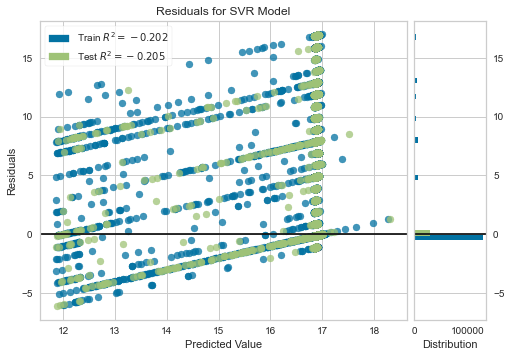

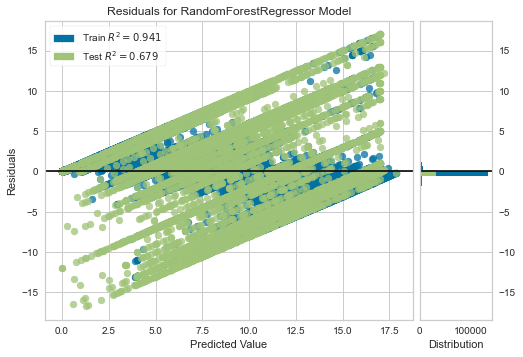

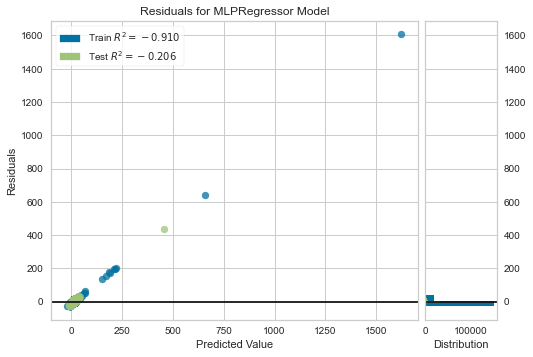

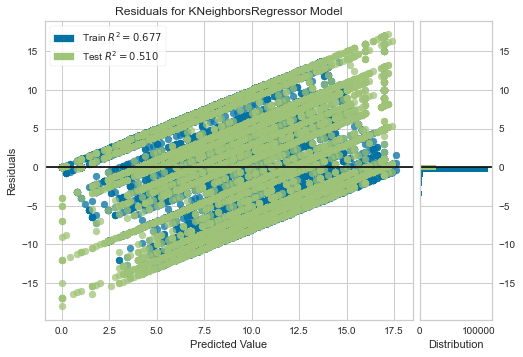

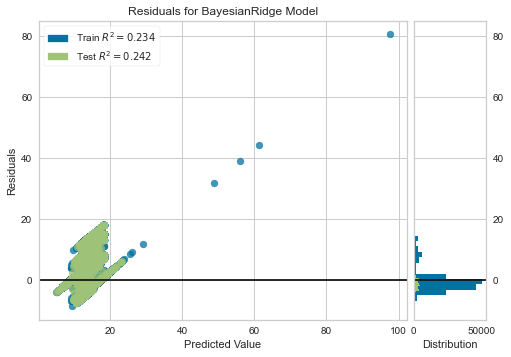

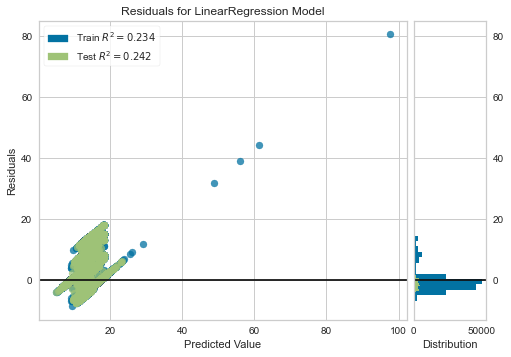

In [44]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import LabelEncoder

# Converting Fuel Model to Numeric and using Label encoders for this 
label_encoder = LabelEncoder()
fires["FireCauseGeneral"] = label_encoder.fit_transform(fires["FireCauseGeneral"].astype(str))

X = fires.drop(['FireCauseGeneral'], axis=1).values
y = fires['FireCauseGeneral'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)



regressors = {
    "support vector machine": SVR(),
    "random forest": RandomForestRegressor(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

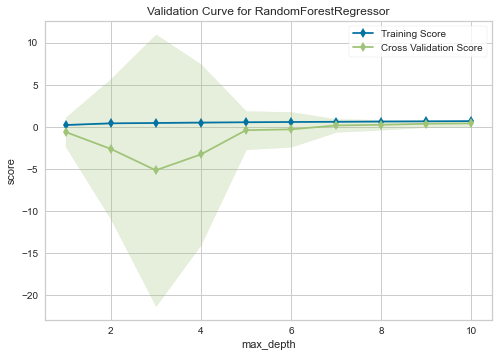

<AxesSubplot:title={'center':'Validation Curve for RandomForestRegressor'}, xlabel='max_depth', ylabel='score'>

In [45]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    RandomForestRegressor(), param_name="max_depth", 
    param_range=np.arange(1, 11), cv=10, scoring="r2")

# Fit and show the visualizer
viz.fit(X,y)
viz.show()